# Model training for Scikit-learn based models 

This file will train machine learning models using the most important 10 questions from DASS-42 from both the MRMR and the Extra Tree classifier.

Firstly, import the relevant libraries.

In [29]:
# Import libraries
import argparse
import pandas as pd
import numpy as np
import scipy
import os
import random
import pickle
import matplotlib.pyplot as plt
from sklearn.metrics import (classification_report, balanced_accuracy_score, confusion_matrix, 
                roc_auc_score, accuracy_score, roc_curve, RocCurveDisplay)

from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC, LinearSVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, StackingClassifier
from xgboost import XGBClassifier
from sklearn.neural_network import MLPClassifier
import warnings

warnings.filterwarnings("ignore")


Define a helper function to calculate confidence intervals. 

In [30]:
def confidence_interval(data, confidence=0.95):
    # Calculate confidence interval
    a = 1.0 * np.array(data)
    n = len(a)
    m, se = np.mean(a), scipy.stats.sem(a)
    h = se * scipy.stats.t.ppf((1 + confidence) / 2.0, n-1)
    return m-h, m+h

The code below enables the script to be executed from the command line with the --type argument to specify the machine learning model type. If the --type argument is not provided, Logistic Regression is used. 

The user can choose one of the available models specified in the choices list, namely lr (Logistic Regression), xgb (XGBoost), rf (Random Forest), svm (Support Vector Machine), mlp (Multilayer Perceptron Neural Network), gnb (Gaussian Naive Bayes), ensemble (Stacked Generalization Ensemble).

In [31]:
parser = argparse.ArgumentParser(description='Model type')
parser.add_argument('--type',
                    default='lr',
                    const='lr',
                    nargs='?',
                    choices=['lr', 'xgb', 'rf', 'svm', 'mlp', 'gnb', 'ensemble'],
                    help='Model types: lr (Logistic Regression), xgb (XGBoost), rf (Random Forest), svm (Support Vector Machine), mlp (Multilayer Perceptron Neural Network), gnb (Gaussian Naive Bayes), ensemble (Stacked Generalization Ensemble). Default: lr')
# args = parser.parse_args()
args, unknown = parser.parse_known_args()

Next, define the constants and variables used.

In [40]:
question_numbers = [1, 2, 3, 4, 5, 6, 7, 8]         # Numbers of questions from DASS to run through
target = "anxiety_status"
models_to_train = 10        # Number of models for each number of questions from DASS
models_per_question = 50    # Number of ensembles per model
test_split = 0.1
model_type = args.type      # Specify model type (xgb, rf, lr, svm, mlp)
seed = 42
random.seed(seed)


ACCS = []
AUCS = []
PRES = []
RECS = []
F1S = []
AUC_STDEV = []
F1_STDEV = []
AUC_95CI_U = []
AUC_95CI_D = []
F1_95CI_U = []
F1_95CI_D = []


data_folder = "./data"
models_folder = "./models"

Load the features and labels dataset, and define the questions variable for the most important 10 questions.

In [41]:
feats_df = pd.read_csv(os.path.join(data_folder, "features.csv"))
labels_df = pd.read_csv(os.path.join(data_folder, "labels.csv"))

questions = [20, 9, 30, 11, 19, 2, 36, 28, 4, 23]
# questions = [9, 14, 36, 40, 28, 20, 30, 25, 7, 41]

Initialise the variables used to store the models and performance scores (such as accuracy, AUC, precision, recall, and f1 score).

Then, train the machine learning models that predict low vs. high anxiety levels, based on combinations of the top 10 DASS-42 questions identified from the feature selection, as well as demographic features in the dataset including age, gender, and region.

The training loop will do data recombination, partitioning, and training/testing 50 times.

The best-performing models were chosen and retrained.

In [42]:
# For different numbers of questions from DASS-42
for num_questions in question_numbers:
    models = {}

    accs = []
    aucs = []
    pres = []
    recs = []
    f1s = []
    auc_stdev = []
    f1_stdev = []
    auc_95ci_u = []
    auc_95ci_d = []
    f1_95ci_u = []
    f1_95ci_d = []
    lst_comb =[]

    model_num = 0
    for a in range(models_to_train):
        model = {}

        print("Training model", a)
        cols = ["gender_m", "gender_f", "region_other", 
                    "region_east", "region_west", "age_norm"]

        if num_questions == 1:
            if a >= len(questions):
                break
            question_nums = [questions[a]]
            
        else:
            question_nums = random.sample(questions, num_questions)
            question_nums.sort()
            #resample if already in list
            while question_nums in lst_comb:
                question_nums = random.sample(questions, num_questions)
            lst_comb.append(question_nums)

        for q in question_nums:
            for j in range(4):
                cols.append("Q{0}A_{1}".format(q, j))
        features = feats_df[cols]

        labels = labels_df[[target]].copy()

        np.random.seed(seed)
        shufId = np.random.permutation(int(len(labels)))
        index = int(test_split * len(labels.index))

        df_prist = features.iloc[shufId[0:index]]
        df_trainvalid = features.iloc[shufId[index:-1]]

        gt_prist = labels.iloc[shufId[0:index]]
        gt_trainvalid = labels.iloc[shufId[index:-1]]

        df_prist.to_csv(os.path.join(data_folder, "prist_features.csv"), index=False)
        gt_prist.to_csv(os.path.join(data_folder, "prist_labels.csv"), index=False)

        accs1 = []
        aucs1 = []
        pres1 = []
        recs1 = []
        f1s1 = []
        ensemble_models = []

        for b in range(models_per_question):
            if b % 10 == 0:
                print("Training iteration", b)

            np.random.seed(b)
            shufId = np.random.permutation(int(len(gt_trainvalid)))
            index = int((1/9) * len(gt_trainvalid.index))

            df_valid = df_trainvalid.iloc[shufId[0:index]]
            df_train = df_trainvalid.iloc[shufId[index:-1]]

            gt_valid = gt_trainvalid.iloc[shufId[0:index]]
            gt_train = gt_trainvalid.iloc[shufId[index:-1]]

            df_valid = df_valid.reset_index(drop=True)
            df_train = df_train.reset_index(drop=True)

            gt_valid = gt_valid.reset_index(drop=True)
            gt_train = gt_train.reset_index(drop=True)

            if model_type == "lr":
                clf = LogisticRegression(random_state=0)
            elif model_type == "gnb":
                clf = GaussianNB()
            elif model_type == "svm":
                clf = SVC(cache_size=7000)
            elif model_type == "rf":
                clf = RandomForestClassifier(max_depth=None, max_features=18, min_samples_split=2, n_estimators=200, random_state=0)
            elif model_type == "xgb":
                clf = XGBClassifier(n_estimators=125, max_depth = 11, objective="reg:logistic", n_jobs=-1, eta=0.29)
            elif model_type == "mlp":
                clf = MLPClassifier()
            elif model_type == "ensemble":
                clf1 = LogisticRegression()
                clf2 = SVC()
                clf3 = RandomForestClassifier()
                clf4 = XGBClassifier()
                clf5 = MLPClassifier()
                clf6 = GaussianNB()
                clf = StackingClassifier([('lr', clf1), ('svm', clf2), ('rf', clf3), ('xgb', clf4), ('mlp', clf5), ('gnb', clf6)], 
                                        final_estimator=LogisticRegression())
            else:
                print("INVALID MODEL TYPE")
            clf.fit(df_train, gt_train.values.ravel())

            xgbpprist = clf.predict(df_prist)
            xgbpprist = pd.DataFrame(xgbpprist)

            # Evaluation
            target_names = ['negative', 'positive']
            cr = classification_report(gt_prist, xgbpprist, target_names=target_names, output_dict=True)
            precision = cr["weighted avg"]["precision"]
            recall = cr["weighted avg"]["recall"]
            f1score = cr["weighted avg"]["f1-score"]

            acc_score = accuracy_score(gt_prist, xgbpprist)
            auc_score = roc_auc_score(gt_prist, xgbpprist)
            fpr, tpr, thresh = roc_curve(gt_prist, xgbpprist)
            plt.plot(fpr, tpr)           

            accs1.append(acc_score)
            aucs1.append(auc_score)
            pres1.append(precision)
            recs1.append(recall)
            f1s1.append(f1score)
            ensemble_models.append(clf)

        mean_acc1 = np.mean(accs1)
        mean_auc1 = np.mean(aucs1)
        stdev_auc1 = np.std(aucs1)
        ci_auc1_u, ci_auc1_d = confidence_interval(aucs1)
        mean_pre1 = np.mean(pres1)
        mean_rec1 = np.mean(recs1)
        mean_f11 = np.mean(f1s1)
        stdev_f11 = np.std(f1s1)
        ci_f11_u, ci_f11_d = confidence_interval(f1s1)

        accs.append(mean_acc1)
        aucs.append(mean_auc1)
        auc_stdev.append(stdev_auc1)
        auc_95ci_u.append(ci_auc1_u)
        auc_95ci_d.append(ci_auc1_d)
        pres.append(mean_pre1)
        recs.append(mean_rec1)
        f1s.append(mean_f11)
        f1_stdev.append(stdev_f11)
        f1_95ci_u.append(ci_f11_u)
        f1_95ci_d.append(ci_f11_d)

        model["questions"] = question_nums
        model["models"] = ensemble_models
        model["auc_score"] = mean_auc1
        model["f1_score"] = mean_f11

        models[model_num] = model
        model_num += 1

    mean_acc = np.mean(accs)
    mean_auc = np.mean(aucs)
    stdev_auc = np.mean(auc_stdev)
    ci_auc_u = np.mean(auc_95ci_u)
    ci_auc_d = np.mean(auc_95ci_d)
    mean_pre = np.mean(pres)
    mean_rec = np.mean(recs)
    mean_f1  = np.mean(f1s)
    stdev_f1 = np.mean(f1_stdev)
    ci_f1_u = np.mean(f1_95ci_u)
    ci_f1_d = np.mean(f1_95ci_d)

    percentile_list = pd.DataFrame(
    {
        'accuracy': accs,
        'auc_roc': aucs,
        'auc_stdev': auc_stdev,
        'auc_95ci_u': auc_95ci_u,
        'auc_95ci_d': auc_95ci_d,
        'precision': pres,
        'recall': recs,
        'f1_score': f1s,
        'f1_stdev': f1_stdev,
        'f1_95ci_u': f1_95ci_u,
        'f1_95ci_d': f1_95ci_d,
    })
    percentile_list.to_csv('./data/results_{}.csv'.format(model_type), mode='a', header=True)

    print("\nNumber of questions:", num_questions)
    print("Mean AUC      :", mean_auc)
    print("Stdev AUC     :", stdev_auc)
    print("95th CI AUC   :", ci_auc_u, ci_auc_d)
    print("Mean F1-Score :", mean_f1)
    print("Stdev F1      :", stdev_f1)
    print("95th CI F1    :", ci_f1_u, ci_f1_d)

    ACCS.append(mean_acc)
    AUCS.append(mean_auc)
    AUC_STDEV.append(stdev_auc)
    AUC_95CI_U.append(ci_auc_u)
    AUC_95CI_D.append(ci_auc_d)
    PRES.append(mean_pre)
    RECS.append(mean_rec)
    F1S.append(mean_f1)
    F1_STDEV.append(stdev_f1)
    F1_95CI_U.append(ci_f1_u)
    F1_95CI_D.append(ci_f1_d)

    with open("./data/models_{}.bin".format(model_type), "wb") as f:
        pickle.dump(models, f)

Training model 0
Training iteration 0


ValueError: multi_class must be in ('ovo', 'ovr')

In [35]:
# Print results
print("\nAll accuracies:", ACCS)
print("All AUCs:", AUCS)
print("Stdev of AUCs:", AUC_STDEV)
print("95th CI of AUCs:", AUC_95CI_U)
print("95th CI of AUCs:", AUC_95CI_D)
print("All precisions:", PRES)
print("All recalls:", RECS)
print("All F1s:", F1S)
print("Stdev of F1s:", F1_STDEV)
print("95th CI of F1s:", F1_95CI_U)
print("95th CI of F1s:", F1_95CI_D)


All accuracies: [0.7639130434782607, 0.8210217391304349, 0.851891304347826, 0.8737826086956522, 0.8883695652173913, 0.8881956521739129, 0.9068913043478257, 0.9157173913043476]
All AUCs: [0.7660662878787878, 0.8219469696969697, 0.852498106060606, 0.8748295454545454, 0.8886098484848484, 0.8882462121212121, 0.9067651515151514, 0.914596590909091]
Stdev of AUCs: [0.009068611158333848, 0.009695791642409012, 0.007831856822997476, 0.008970863934232996, 0.009106393540335479, 0.008832383849869549, 0.008470340396243465, 0.0089903248746182]
95th CI of AUCs: [0.7634628512475103, 0.8191634807271198, 0.8502497195560009, 0.8722541703091327, 0.8859955652051038, 0.8857105921398523, 0.9043334677565307, 0.9120156288745509]
95th CI of AUCs: [0.7686697245100652, 0.8247304586668196, 0.8547464925652113, 0.8774049205999586, 0.891224131764593, 0.8907818321025719, 0.9091968352737725, 0.9171775529436308]
All precisions: [0.776883853612041, 0.8251942895323436, 0.8544279218113997, 0.8771750833946752, 0.88997313622

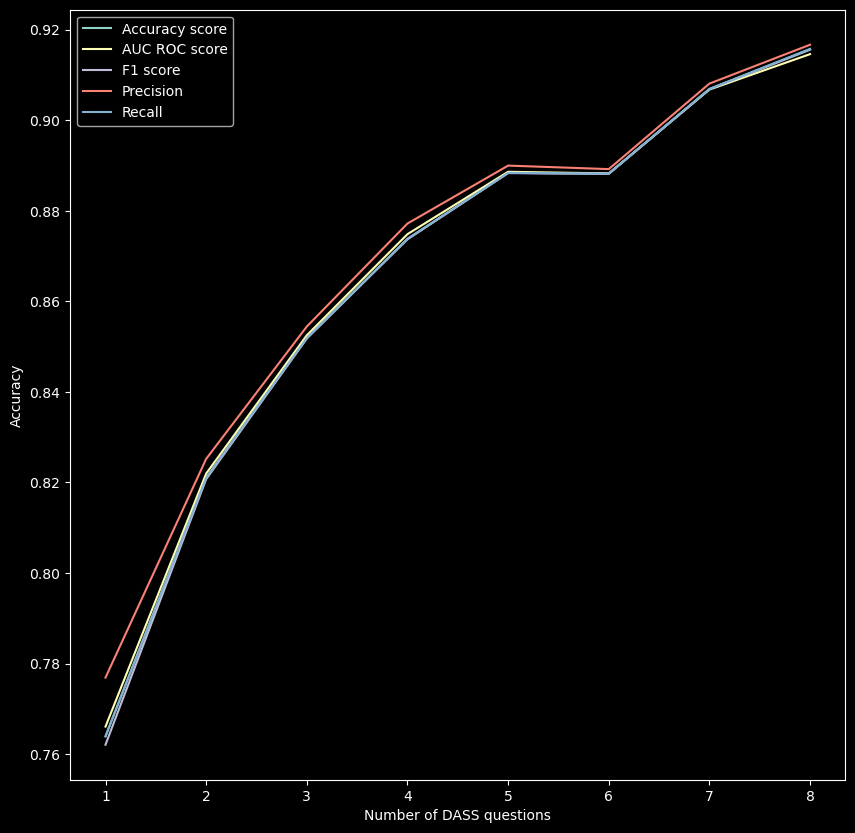

In [36]:
# Plot accuracy results
plt.figure(figsize=(10,10)) # Make new figure
plt.plot(question_numbers, ACCS)
plt.plot(question_numbers, AUCS)
plt.plot(question_numbers, F1S)
plt.plot(question_numbers, PRES)
plt.plot(question_numbers, RECS)
plt.xlabel("Number of DASS questions")
plt.ylabel("Accuracy")
plt.legend(["Accuracy score", "AUC ROC score", "F1 score", "Precision", "Recall"])
plt.show()